In [ ]:
!pip install seaborn

In [2]:
!pip install python-dotenv

In [ ]:
!pip install mysqlclient

In [24]:
import seaborn
from matplotlib.pyplot import hist
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values
from sqlalchemy import text

In [5]:
config = dotenv_values("database_URL.env")
url = config['DATABASE_URL']
engine = create_engine(url, echo=False)

In [ ]:
with engine.begin() as conn:
    query = text("select * from target_to_compounds;")
    target_list = pd.read_sql(query, conn)
display(target_list)

In [7]:
three_col_list = target_list[['assay_id', 'assay_description', 'abstract']].copy()

In [8]:
unique_list = []
for index, row in three_col_list.iterrows():
    if (row["assay_id"], row["assay_description"], row["abstract"]) in unique_list:
        continue
    else:
        unique_list.append((row["assay_id"], row["assay_description"], row["abstract"]))

Assay_Descriptions = [abstract for (assay_ids, assay_name, abstract) in unique_list]
Assay_Descriptions_Joined = ':: '.join(Assay_Descriptions)

print(len(unique_list))

1247


In [9]:
Assay_Descriptions_List = Assay_Descriptions

In [10]:
Assay_Count_Vect = CountVectorizer()
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)
n_clusters = 10
X = Assay_Train_Counts.toarray()

In [34]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)
tf_idf_vector = tfidf_transformer.transform(Assay_Train_Counts)

In [ ]:
ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)

adding largest cluster size

In [31]:
unique_labels, counts = np.unique(ward.labels_, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

In [32]:
largest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)
largest_cluster_size = cluster_sizes[largest_cluster_label]

print(f"largest cluster: Cluster {largest_cluster_label}, Size: {largest_cluster_size}")

largest cluster: Cluster 3, Size: 418


attempting to print cluster descriptions here

In [35]:
cluster_labels = ward.fit_predict(tf_idf_vector.toarray())

*   cluster_assay_descriptions - empty dictionary for assay descriptions
*   zip function combines cluster labels and assay descriptions so each cluster label has a matching assay description






In [36]:
cluster_assay_descriptions = {}
for cluster_label, assay_description in zip(cluster_labels, Assay_Descriptions):
    if cluster_label not in cluster_assay_descriptions:
        cluster_assay_descriptions[cluster_label] = []
    cluster_assay_descriptions[cluster_label].append(assay_description)

In [37]:
sorted_clusters = sorted(cluster_assay_descriptions.keys())

In [40]:
for cluster_label in sorted_clusters:
    assay_descriptions = cluster_assay_descriptions[cluster_label]
    print(f"Cluster {cluster_label}: {assay_descriptions[0]}")

Cluster 0: 
Cluster 1: Rash is one of the primary dose-limiting toxicities of Akt (protein kinase B) inhibitors in clinical trials. Here, we demonstrate the inhibition of Akt2 isozyme may be a driver for keratinocyte apoptosis, which promotes us to search for new selective Akt inhibitors with an improved cutaneous safety property. According to our previous research, compound <b>2</b> is selected for further optimization for overcoming the disadvantages of compound <b>1</b>, including high Akt2 inhibition and high toxicity against HaCaT keratinocytes. The dihedral angle-based design and molecular dynamics simulation lead to the identification of <b>Hu7691</b> (<b>B5</b>) that achieves a 24-fold selectivity between Akt1 and Akt2. <b>Hu7691</b> exhibits low activity in inducing HaCaT apoptosis, promising kinase selectivity, and excellent anticancer cell proliferation potencies. Based on the superior results of safety property, pharmacokinetic profile, and <i>in vivo</i> efficacy, the Nati

back to regular code

In [42]:
print(ward.distances_)
print(ward.distances_.shape)

[0.         0.         0.         ... 4.04884112 4.50459408 4.88960546]
(1246,)


In [43]:
X_Hist = ward.distances_
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

[0.74882982 0.74882982 0.74882982 ... 0.0054859  0.00203401 0.00181907]


In [ ]:
seaborn.clustermap(X,method='ward')

In [45]:
df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names_out(),columns=["idf_weights"])

In [ ]:
df_idf.sort_values(by=['idf_weights'])


In [47]:
count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)

In [ ]:
tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)
tf_idf_vector.shape

In [49]:
feature_names = Assay_Count_Vect.get_feature_names_out()


In [50]:
first_document_vector=tf_idf_vector[0]


In [ ]:
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


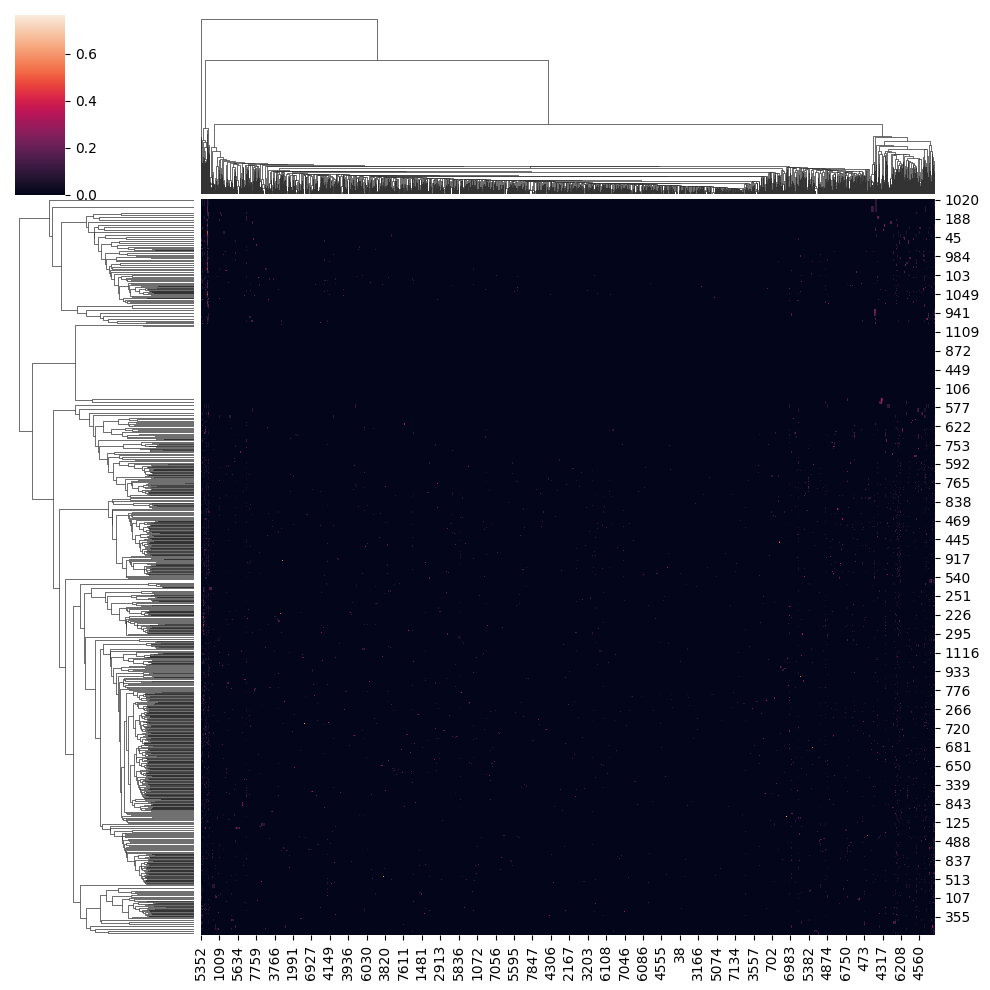

In [52]:
seaborn.clustermap(tf_idf_vector.toarray(),method='ward')